In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

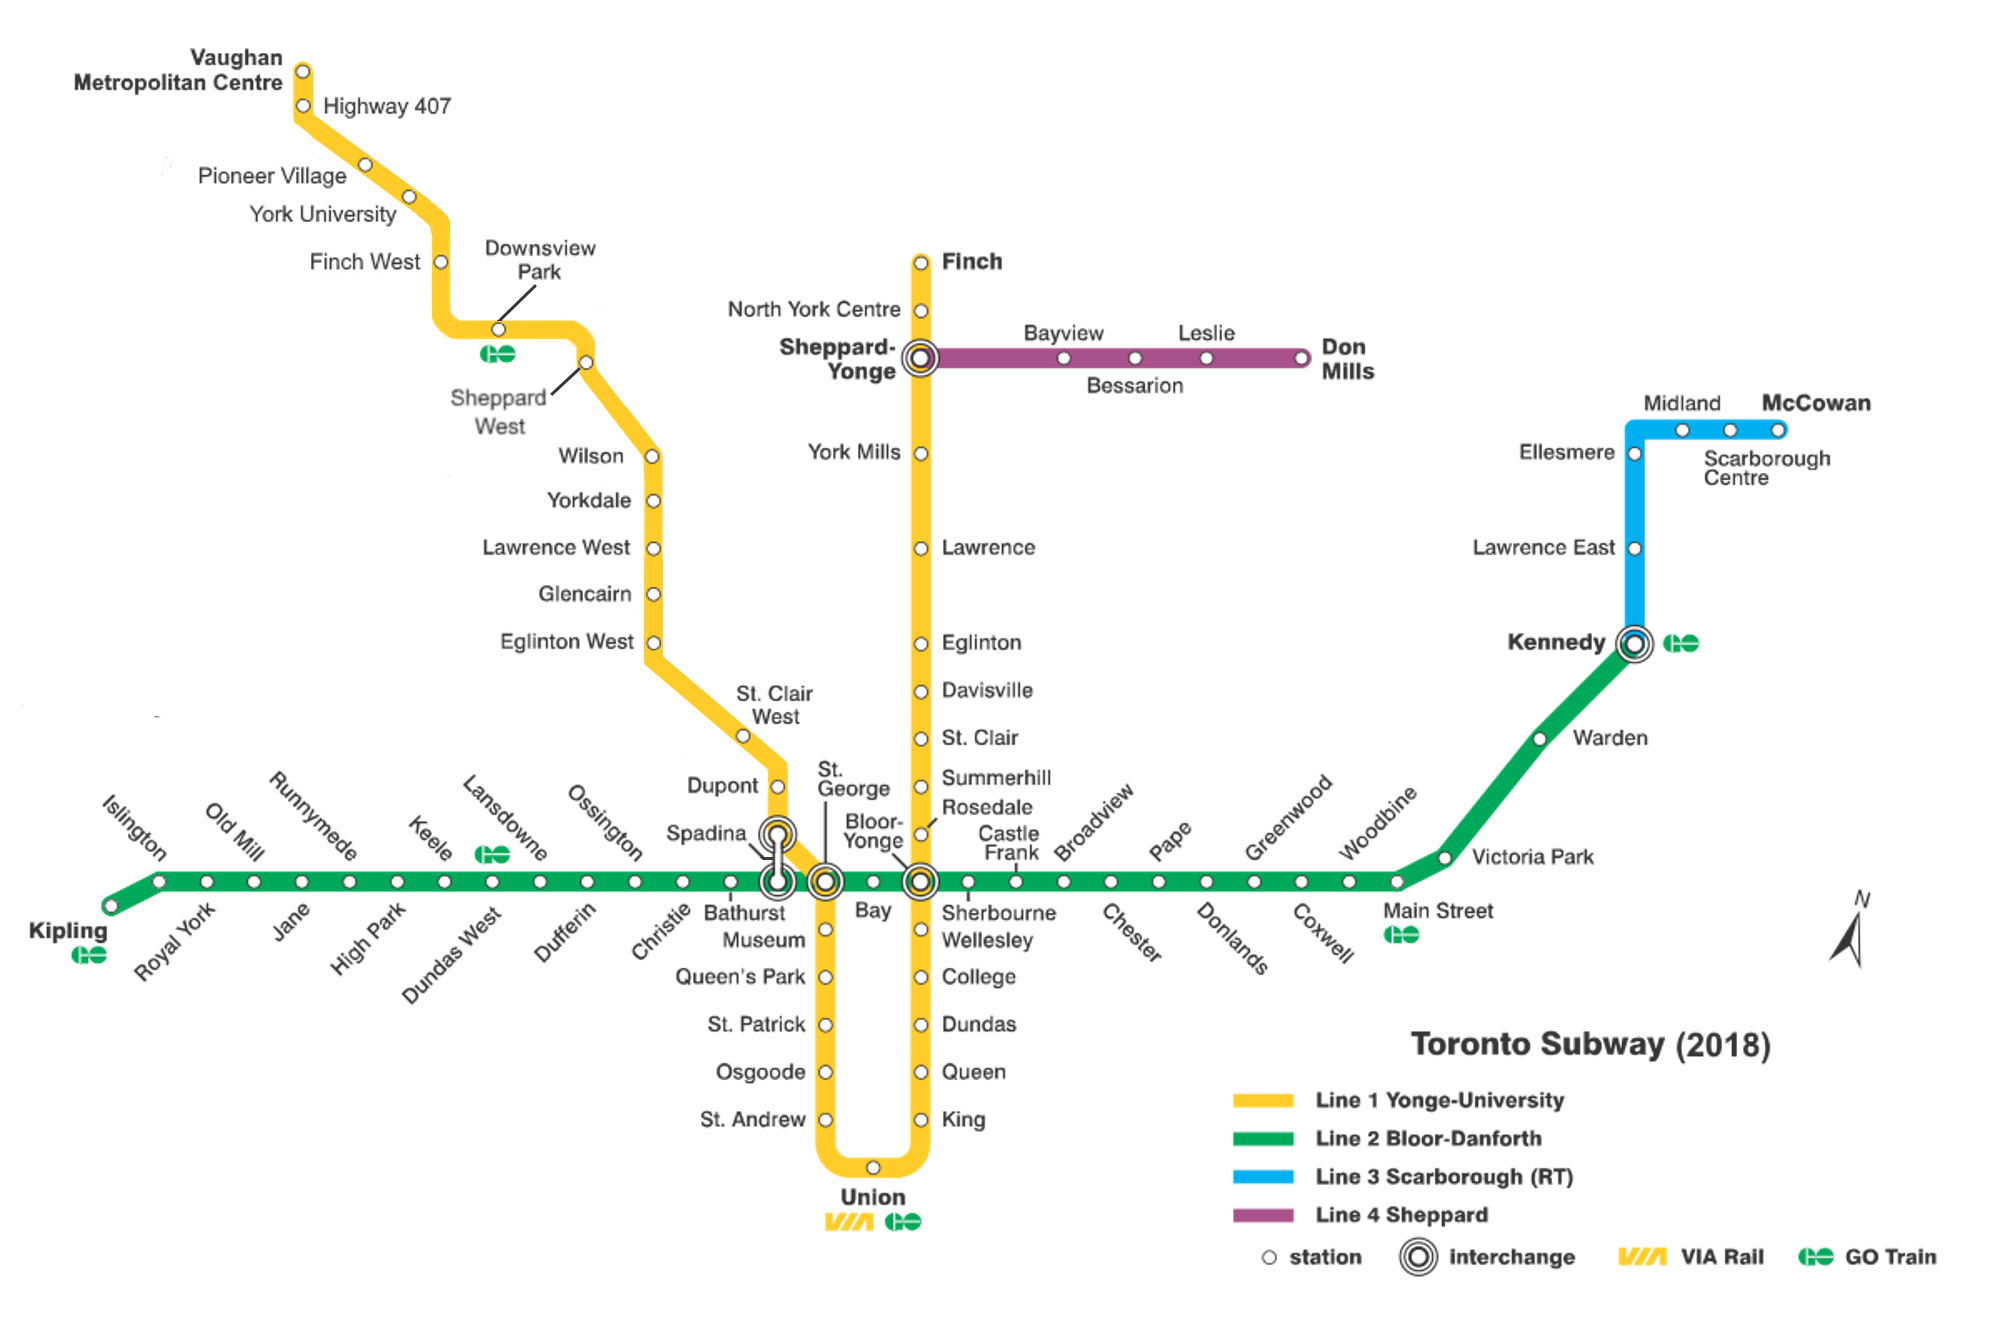
By Transportfan70 (Original by Craftwerker) - File:TTC_subway_map_2015.svg, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=64106028

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('/kaggle/input/toronto-subway-delay-data/Toronto-Subway-Delay-Jan-2014-Jun-2021.csv')
df_code=pd.read_csv('/kaggle/input/toronto-subway-delay-data/Toronto-Subway-Delay-Codes.csv')

In [ ]:
df

In [ ]:
df.dtypes

In [ ]:
df.isnull().sum()

In [ ]:
from datetime import datetime as dt

In [ ]:
df['Date']=pd.to_datetime(df['Date'])
df['Time']=pd.to_datetime(df['Time'])

In [ ]:
df['Year']=df['Date'].dt.year
df['Month']=df['Date'].dt.month
df['Days']=df['Date'].dt.day
df['Hour']=df['Time'].dt.hour

In [ ]:
df

# 1. Time Seriea Analysis

# 1) Time Series

In [ ]:
df_ts=df.groupby('Date')['Code'].count()
df_ts.plot(figsize=(30,10))

# 2) Prediction Model by RNN and LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [ ]:
df_ts=pd.DataFrame(df_ts)
df_ts=df_ts.reset_index()
df_ts=df_ts.rename(columns={'Code': 'Num'})
df_ts=df_ts.drop('Date',axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
dataset = df_ts

train = dataset[0:2130]
valid = dataset[2130:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

inputs = df_ts[len(df_ts) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred_close2 = model.predict(X_test)
pred_close2 = scaler.inverse_transform(pred_close2)

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-pred_close2),2)))
rms

In [ ]:
train = df_ts[:2130]
valid = df_ts[2130:]
valid['Predictions'] = pred_close2
plt.figure(figsize=(30,10))
plt.plot(train['Num'])
plt.plot(valid[['Num','Predictions']])

In [ ]:
train = df_ts[:2130]
valid = df_ts[2130:]
plt.figure(figsize=(30,10))
valid['Predictions'] = pred_close2
plt.plot(valid[['Num','Predictions']])

# 3) Prediction Model by Prophet

In [ ]:
df_ts=df.groupby('Date')['Code'].count()
df_ts=pd.DataFrame(df_ts)
df_ts=df_ts.reset_index()

In [ ]:
from fbprophet import Prophet
import datetime

df_ts.rename(columns={'Code': 'y', 'Date': 'ds'}, inplace=True)

train = df_ts[:2130]
valid = df_ts[2130:]

model = Prophet()
model.fit(train)

pred = model.make_future_dataframe(periods=608, freq = 'd')
forecast = model.predict(pred)

In [ ]:
forecast_valid = forecast['yhat'][2130:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

In [ ]:
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.figure(figsize=(30,10))
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(forecast[['trend','yhat_lower','yhat_upper']])

# 2. Top 100 longest Delay Analysis

In [ ]:
df_100delay=df.sort_values('Min Delay', ascending=False).head(100)

# 1) Top 100 Longest Delay Analysis by Stations, Lines, Cause(Code) and Min Delay 

In [ ]:
df_100delay

In [ ]:
plt.figure(figsize=(12, 12))
plt.legend(fontsize=10)
plt.tick_params(labelsize=10)
ax=sns.scatterplot(x=df_100delay['Code'],y=df_100delay['Station'],hue=df_100delay['Line'],size=df_100delay['Min Delay'],data=df_100delay,sizes=(50,500))
plt.setp(ax.get_xticklabels(), rotation=90)
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

# 2) Top 100 Longest Delay Analysis by Days,Weekday and Hour

In [ ]:
plt.figure(figsize=(12, 12))
plt.legend(fontsize=10)
plt.tick_params(labelsize=10)
ax=sns.scatterplot(x=df_100delay['Days'],y=df_100delay['Hour'],hue=df_100delay['Day'],size=df_100delay['Min Delay'],data=df_100delay,sizes=(50,500))
plt.setp(ax.get_xticklabels(), rotation=90)
ax.legend(loc='upper left',bbox_to_anchor=(1,1))

# 3. High Frequency Delay Analysis

# 1) Delay Frequency by Year(2021 includes only 6 months)

In [ ]:
df.groupby('Year')['Code'].count().plot.bar(figsize=(10,10))

# 2) Delay Frequency by Mpnth (July to December do not include 2021)

In [ ]:
df.groupby('Month')['Code'].count().plot.bar(figsize=(10,10))

# 3) Delay Frequency by Days

In [ ]:
df.groupby('Days')['Code'].count().plot.bar(figsize=(20,10))

# 4) Delay Frequency by Day of Week

In [ ]:
df.groupby('Day')['Code'].count().plot.bar(figsize=(10,10))

# 5) Delay Frequency by Hour

In [ ]:
df.groupby('Hour')['Code'].count().plot.bar(figsize=(20,10))

# 6) Top 100 Stations which have most frequent delay

In [ ]:
df.groupby('Station')['Code'].count().sort_values(ascending=False).head(100).plot.bar(figsize=(20,10))

# 7) Top 50 Delay Cause (Code) which cause most frequent delay

In [ ]:
df.groupby('Code')['Code'].count().sort_values(ascending=False).head(50).plot.bar(figsize=(20,10))

# 8) Lines which have most frequent delay

In [ ]:
df.groupby('Line')['Code'].count().sort_values(ascending=False).head(50).plot.bar(figsize=(10,10))

# 9) Vehicles which have most frequent delay

In [ ]:
df.groupby('Vehicle')['Code'].count().sort_values(ascending=False).head(50).plot.bar(figsize=(10,10))

# 10) Delay Frequency Top 100 Analysis by Cause(Code), Station and Lines

In [ ]:
df1=pd.DataFrame(df.groupby(['Station','Code','Line'])['Code'].count())

In [ ]:
df1=df1.rename(columns={'Code': 'num'})
df1=df1.reset_index()

In [ ]:
df1=df1.sort_values('num',ascending=False).head(100)

In [ ]:
df1

In [ ]:
plt.figure(figsize=(12, 12))
plt.legend(fontsize=10)
plt.tick_params(labelsize=10)
ax=sns.scatterplot(x=df1['Code'],y=df1['Station'],hue=df1['Line'],size=df1['num'],data=df1,sizes=(50,500))
ax.legend(loc='upper left',bbox_to_anchor=(1,1))